# Задача:
Решить задачу регрессии.
Получить максимальную метрику качества (R2, RMSE).

Введение
Целью данной задачи является прогнозирование суммы пятничных распродаж в магазинах сети Walmart с помощью построения регрессионных моделей и их анализа.
Набор данных состоит из исторических данных, которые охватывают продажи с 2010-02-05 по 2012-11-01, предствленных в файле Walmart.csv
#Использовать приплайны.
#Выполнить поиск лучших параметров / *hyperopt / **optuna
#Кроссвалидация / различные типы проверок.
#Сохранить и загрузить моделль. 
#H20 (если получиться)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 80)

In [2]:
# Прочитаем файл данных
df = pd.read_csv("./Walmart.csv", encoding='ANSI', on_bad_lines = 'skip', index_col = "Date")
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
05-02-2010,1,1643690.90,0,42.31,2.572,211.096358,8.106
12-02-2010,1,1641957.44,1,38.51,2.548,211.242170,8.106
19-02-2010,1,1611968.17,0,39.93,2.514,211.289143,8.106
26-02-2010,1,1409727.59,0,46.63,2.561,211.319643,8.106
05-03-2010,1,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
28-09-2012,45,713173.95,0,64.88,3.997,192.013558,8.684
05-10-2012,45,733455.07,0,64.89,3.985,192.170412,8.667
12-10-2012,45,734464.36,0,54.47,4.000,192.327265,8.667


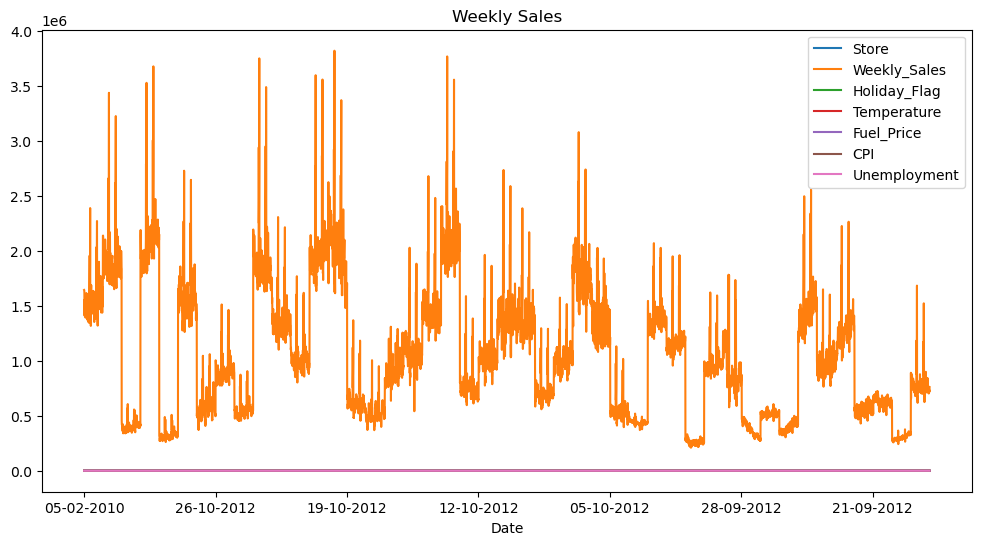

In [3]:
#Визуализация данных
df.plot(figsize = (12, 6))
plt.title("Weekly Sales")
plt.show()

In [4]:
# Проверка на пропущенные значения
print(df.isnull().sum())

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Разделение на признаки и целевую переменную
X = df.drop('Weekly_Sales', axis=1)  
y = df['Weekly_Sales'] 

In [8]:
# Извлечение признаков из даты
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek

AttributeError: 'DataFrame' object has no attribute 'month'

In [9]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Создание пайплайна для предобработки данных
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), MinMaxScaler(), SVC(C=100))


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Определение числовых и категориальных признаков
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'DayOfWeek']
categorical_features = ['Store', 'Holiday_Flag']

# Создание пайплайна для предобработки данных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Пайплайн для линейной регрессии
linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Пайплайн для случайного леса
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Пайплайн для градиентного бустинга
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


In [12]:
#Обучение и оценка моделей с использованием кросс-валидации
from sklearn.model_selection import cross_val_score
import numpy as np

# Функция для оценки моделей с использованием кросс-валидации
def evaluate_model(pipeline, X, y, cv=5):
    r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error'))
    return r2_scores.mean(), rmse_scores.mean()

# Оценка линейной регрессии
linear_r2, linear_rmse = evaluate_model(linear_pipeline, X_train, y_train)
print(f"Linear Regression - R2: {linear_r2}, RMSE: {linear_rmse}")

# Оценка случайного леса
rf_r2, rf_rmse = evaluate_model(rf_pipeline, X_train, y_train)
print(f"Random Forest - R2: {rf_r2}, RMSE: {rf_rmse}")

# Оценка градиентного бустинга
gb_r2, gb_rmse = evaluate_model(gb_pipeline, X_train, y_train)
print(f"Gradient Boosting - R2: {gb_r2}, RMSE: {gb_rmse}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Month'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'Month'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [ ]:
# Обучение лучшей модели на всей обучающей выборке
best_pipeline = gb_pipeline  # Предположим, что градиентный бустинг показал лучшие результаты
best_pipeline.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = best_pipeline.predict(X_test)

# Оценка на тестовой выборке
from sklearn.metrics import r2_score, mean_squared_error

final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Model - R2: {final_r2}, RMSE: {final_rmse}")